In [1]:
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
tracing_v2 = os.getenv("LANGCHAIN_TRACING_V2")
api_key = os.getenv("LANGCHAIN_API_KEY")
endpoint = os.getenv("LANGCHAIN_ENDPOINT")
project = os.getenv("LANGCHAIN_PROJECT")


In [5]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-1.0-pro",convert_system_message_to_human=True)

In [7]:
print(model.invoke('hi').content)

Hello there! How can I assist you today?


In [8]:
import bs4
from langchain import hub

In [9]:
from langchain.chains import create_retrieval_chain

In [10]:
from langchain.chains.combine_documents import create_stuff_documents_chain

In [11]:
from langchain_chroma import Chroma 

In [12]:
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [13]:
from langchain_core.prompts import ChatPromptTemplate

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [15]:
from langchain_core.prompts import MessagesPlaceholder

In [16]:
#Post request
# header, content, title will be retrieved from the web page
loader = WebBaseLoader(web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),bs_kwargs=dict(parse_only=bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))),)

In [17]:
# Load the doc from the webpage
doc = loader.load()

In [18]:

doc

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [19]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap = 200)
chunks = text_splitter.split_documents(doc)

In [20]:
vectorstore = Chroma.from_documents(documents= chunks, embedding = gemini_embeddings)
retriever = vectorstore.as_retriever()

In [21]:
retriever 

VectorStoreRetriever(tags=['Chroma', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x000001A2C5FDB010>)

In [22]:
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question "
    "If you don't know the answer, say that you don't know."
    "Use three sentences maximum and keep the answer concise."
    "\n\n"
    "{context}"
)

In [23]:
chat_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [24]:
question_answering_chain = create_stuff_documents_chain(model, chat_prompt)

In [25]:
rag_chain = create_retrieval_chain(retriever, question_answering_chain)

In [26]:
response = rag_chain.invoke({"input":"what is MRKL?"})

In [27]:
response["answer"]

'MRKL (Modular Reasoning, Knowledge and Language) is a neuro-symbolic architecture for autonomous agents that contains expert modules and a large language model (LLM) as a router. The LLM directs inquiries to the most appropriate expert module, which can be either neural or symbolic.'

In [28]:
from langchain.chains import create_history_aware_retriever

In [29]:
retriever_prompt = (
    "Given a chat history and the latest user question which might reference context in the chat history,"
    "formulate a standalone question which can be understood without the chat history."
    "Do NOT answer the question, just reformulate it if needed and otherwise return it as is."
)

In [30]:
contextualize_q_prompt  = ChatPromptTemplate.from_messages(
    [
        ("system", retriever_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
     ]
)

In [31]:
history_aware_retriever = create_history_aware_retriever(model,retriever,contextualize_q_prompt)

In [32]:
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

In [33]:
question_answer_chain = create_stuff_documents_chain(model, qa_prompt)

In [34]:
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

In [35]:
from langchain_core.messages import HumanMessage, AIMessage 

In [36]:
chat_history = []

In [37]:
question1 = "what is Task Decomposition?"

In [38]:
message1= rag_chain.invoke({"input": question1, "chat_history": chat_history})

In [39]:
message1["answer"]

'Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. \nThis can be done by using a LLM with simple prompting, by using task-specific instructions, or with human inputs. \nTask decomposition can help to improve model performance on complex tasks and shed light into an interpretation of the model’s thinking process.'

In [40]:
chat_history.extend(
    [
        HumanMessage(content=question1),
        AIMessage(content=message1["answer"]),
    ]
)

In [41]:
chat_history

[HumanMessage(content='what is Task Decomposition?'),
 AIMessage(content='Task decomposition is a technique used to break down complex tasks into smaller, more manageable steps. \nThis can be done by using a LLM with simple prompting, by using task-specific instructions, or with human inputs. \nTask decomposition can help to improve model performance on complex tasks and shed light into an interpretation of the model’s thinking process.')]

In [42]:
second_question = "What are common ways of doing it?"
message2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(message2["answer"])

Common ways of doing task decomposition include:

* Using a LLM with simple prompting, such as "Steps for XYZ.\n1." or "What are the subgoals for achieving XYZ?"
* Using task-specific instructions, such as "Write a story outline." for writing a novel
* With human inputs, such as brainstorming with a team or consulting with an expert

These methods can help to break down complex tasks into smaller, more manageable steps, which can improve model performance and provide insights into the model's thinking process.


In [43]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

In [44]:
store = {}

In [47]:
def get_session_id(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [48]:
conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_id,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [49]:
conversational_rag_chain.invoke(
    {"input": "What is Task Decomposition?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # constructs a key "abc123" in `store`.
)["answer"]

'Task decomposition is a technique used to break down complex tasks into smaller, more manageable subtasks. This can be done using a variety of methods, including LLM prompting, task-specific instructions, or human input. Task decomposition can help to improve model performance on complex tasks by making them more manageable and easier to solve.'

In [50]:
store

{'abc123': InMemoryChatMessageHistory(messages=[HumanMessage(content='What is Task Decomposition?'), AIMessage(content='Task decomposition is a technique used to break down complex tasks into smaller, more manageable subtasks. This can be done using a variety of methods, including LLM prompting, task-specific instructions, or human input. Task decomposition can help to improve model performance on complex tasks by making them more manageable and easier to solve.')])}

In [51]:
conversational_rag_chain.invoke(
    {"input": "What are common ways of doing it?"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]

'Common ways of doing task decomposition include:\n\n- Using LLM prompting to instruct the model to "think step by step" and decompose the task into smaller subtasks.\n- Using task-specific instructions to guide the model in decomposing the task.\n- Providing human input to decompose the task into smaller subtasks.\n\nThese methods can help to improve model performance on complex tasks by making them more manageable and easier to solve.'

In [52]:
for message in store["abc123"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")

User: What is Task Decomposition?

AI: Task decomposition is a technique used to break down complex tasks into smaller, more manageable subtasks. This can be done using a variety of methods, including LLM prompting, task-specific instructions, or human input. Task decomposition can help to improve model performance on complex tasks by making them more manageable and easier to solve.

User: What are common ways of doing it?

AI: Common ways of doing task decomposition include:

- Using LLM prompting to instruct the model to "think step by step" and decompose the task into smaller subtasks.
- Using task-specific instructions to guide the model in decomposing the task.
- Providing human input to decompose the task into smaller subtasks.

These methods can help to improve model performance on complex tasks by making them more manageable and easier to solve.



In [53]:
conversational_rag_chain.invoke(
    {"input": "What is a prompt technique like step xyz?"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]

'A prompt technique like "step xyz" is a type of instruction that can be used to guide a large language model (LLM) in performing a task. The "step xyz" format instructs the LLM to break down the task into a series of smaller, more manageable steps. This can help to improve the LLM\'s performance on complex tasks by making them more structured and easier to solve.\n\nFor example, the following prompt technique could be used to instruct an LLM to write a story:\n\n```\nStep 1: Generate a list of potential story ideas.\nStep 2: Select one story idea and develop a plot outline.\nStep 3: Write a first draft of the story.\nStep 4: Revise and edit the story.\nStep 5: Finalize the story.\n```\n\nBy following this prompt technique, the LLM would be able to break down the task of writing a story into a series of smaller, more manageable steps. This would help to improve the LLM\'s performance on the task by making it more structured and easier to solve.\n\nOther examples of prompt techniques th

In [54]:
for message in store["abc123"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")

User: What is Task Decomposition?

AI: Task decomposition is a technique used to break down complex tasks into smaller, more manageable subtasks. This can be done using a variety of methods, including LLM prompting, task-specific instructions, or human input. Task decomposition can help to improve model performance on complex tasks by making them more manageable and easier to solve.

User: What are common ways of doing it?

AI: Common ways of doing task decomposition include:

- Using LLM prompting to instruct the model to "think step by step" and decompose the task into smaller subtasks.
- Using task-specific instructions to guide the model in decomposing the task.
- Providing human input to decompose the task into smaller subtasks.

These methods can help to improve model performance on complex tasks by making them more manageable and easier to solve.

User: What is a prompt technique like step xyz?

AI: A prompt technique like "step xyz" is a type of instruction that can be used to 

In [55]:
store

{'abc123': InMemoryChatMessageHistory(messages=[HumanMessage(content='What is Task Decomposition?'), AIMessage(content='Task decomposition is a technique used to break down complex tasks into smaller, more manageable subtasks. This can be done using a variety of methods, including LLM prompting, task-specific instructions, or human input. Task decomposition can help to improve model performance on complex tasks by making them more manageable and easier to solve.'), HumanMessage(content='What are common ways of doing it?'), AIMessage(content='Common ways of doing task decomposition include:\n\n- Using LLM prompting to instruct the model to "think step by step" and decompose the task into smaller subtasks.\n- Using task-specific instructions to guide the model in decomposing the task.\n- Providing human input to decompose the task into smaller subtasks.\n\nThese methods can help to improve model performance on complex tasks by making them more manageable and easier to solve.'), HumanMess

In [92]:
response= conversational_rag_chain.invoke(
    {"input": "Explain the last thing more simply"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]

In [93]:
response 

'**Simplified explanation:**\n\nPrompt techniques like "step xyz" help LLMs break down complex tasks into smaller, easier steps. This makes the task more structured and easier to solve, improving the LLM\'s performance.\n\nFor example, instead of giving an LLM the task of "write a story," you could use the following prompt technique:\n\n```\nStep 1: Think of 3 story ideas.\nStep 2: Pick your favorite idea and write an outline.\nStep 3: Write a first draft of your story.\nStep 4: Revise and edit your story.\nStep 5: Finish your story.\n```\n\nBy breaking the task down into smaller steps, the LLM is more likely to be able to complete the task successfully.'

In [94]:
for message in store["abc123"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")

User: What is Task Decomposition?

AI: Task decomposition is a technique used to break down complex tasks into smaller, more manageable subtasks. This can be done using a variety of methods, including LLM prompting, task-specific instructions, or human input. Task decomposition can help to improve model performance on complex tasks by making them more manageable and easier to solve.

User: What are common ways of doing it?

AI: Common ways of doing task decomposition include:

- Using LLM prompting to instruct the model to "think step by step" and decompose the task into smaller subtasks.
- Using task-specific instructions to guide the model in decomposing the task.
- Providing human input to decompose the task into smaller subtasks.

These methods can help to improve model performance on complex tasks by making them more manageable and easier to solve.

User: What is a prompt technique like step xyz?

AI: A prompt technique like "step xyz" is a type of instruction that can be used to 

In [56]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

In [57]:
from langchain_core.tools import tool

In [81]:
workflow = StateGraph(MessagesState)

In [82]:
workflow.add_node("session", get_session_id)

In [83]:
workflow.add_node("chat_history_retriever", history_aware_retriever)

In [84]:
workflow.add_node("context_chunks_retriever", retriever)

In [85]:
workflow.add_edge("chat_history_retriever", "context_chunks_retriever")

In [86]:
workflow.add_edge("session", "chat_history_retriever")

In [87]:
workflow.add_node("model", model)

In [88]:
workflow.add_edge("context_chunks_retriever", "model")

In [89]:
workflow.add_node("prompt", contextualize_q_prompt)

In [90]:
workflow.add_edge("prompt", "session")

In [96]:
workflow.add_node("response", conversational_rag_chain)

In [97]:
workflow.add_edge("model", "response")

In [91]:
workflow.set_entry_point("prompt")

In [98]:
checkpointer = MemorySaver()

In [99]:
app = workflow.compile(checkpointer=checkpointer)

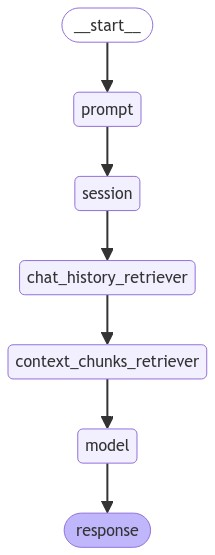

In [100]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass